# Hodgkin-Huxley model of a spiking neuron

In [39]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import find_peaks
from scipy import signal

class HodgkinHuxleyNeuron():
    """Implementation of the classic Hodgkin-Huxley Model of the action potential"""
    
    """Class variables"""
    g_Na = 120.0   # Maximum sodium (Na) conductance density, in uS/nF
    g_K  =  36.0   # Maximum postassium (K) conductance density, in uS/nF
    g_L  =   0.3   # Maximum leak (L) conductance density, in uS/nF
    E_Na =  50.0   # Sodium reversal (Nernst) potential, in mV
    E_K  = -77.0   # Postassium reversal (Nernst) potential, in mV
    E_L  = -54.4   # Leak reversal (Nernst) potential, in mV
    C_m  =   1.0   # Membrane capacitance per unit area, in uF/cm^2
    dt   = 0.001   # Integration time step, in ms
    
    """Constructor and instance variables"""
    def __init__(self, p, T, I, I1=4.5, I2=35.0): 
        """Constructor of a HodgkinHuxleyNeuron object (class instance).
        
        Args: 
            p: pulse width of periodic square wave input
            T: period of periodic square wave input
            I: amplitude of periodic square wave input
            I1: amplitude of first 200-ms-long pulse of input current
            I2: amplitude of second 200-ms-long pulse of input current
        """
        self.p = p
        self.T = T
        self.I = I
        self.I1 = I1
        self.I2 = I2
        
    """Time frame of Hodgkin-Huxley simulation"""
    t = np.arange(0.0, 750.0, 0.01)          # Used for solving ODEs via odeint
    t_Euler = np.arange(0.0, 1000.0, 0.001)  # Used for solving ODEs via forward Euler method
    t_psp = np.arange(0.0, 250.0, 0.001)     # Used for exploring response to periodic square pulse
    
    """Kinetics of ion channel gating: transition rate constants are functions of membrane voltage, but not time"""
    def alpha_m(self, V):
        """Forward rate constant for sodium (Na) channel activation"""
        return (2.5-0.1*(V+65.0)) / (np.exp(2.5-0.1*(V+65)) - 1.0)

    def beta_m(self, V):
        """Backward rate constant for sodium (Na) channel activation"""
        return 4.0*np.exp(-(V+65.0) / 18.0)

    def alpha_h(self, V):
        """Forward rate constant for sodium (Na) channel inactivation"""
        return 0.07*np.exp(-(V+65.0) / 20.0)

    def beta_h(self, V):
        """Backward rate constant for sodium (Na) channel inactivation"""
        return 1/(1.0 + np.exp(3.0-0.1*(V+65.0)))
    
    def alpha_n(self, V):
        """Forward rate constant for potassium (K) channel activation"""
        return (0.1-0.01*(V+65.0)) / (np.exp(1-0.1*(V+65.0)) -1)
    
    def beta_n(self, V):
        """Backward rate constant for potassium (K) channel activation"""
        return 0.125*np.exp(-(V+65.0) / 80.0)
    
    """Membrane currents of ion channels"""
    def I_Na(self, V, m, h):
        """Membrane current through Na channels, in uA/cm^2.
        
        Args:
            V: Membrane voltage
            m: Gating variable for activation of Na channels
            h: Gating variable for inactivation of Na channels
        """
        return self.g_Na * m**3 * h * (V - self.E_Na)

    def I_K(self, V, n):
        """Membrane current through K channels, in uA/cm^2.
        
        Args:
            V: Membrane voltage
            n: Gating variable for activation of K channels
        """
        return self.g_K  * n**4 * (V - self.E_K)

    def I_L(self, V):
        """Membrane current through leak channels, in uA/cm^2"""
        return self.g_L * (V - self.E_L)

    def I_inj(self, t):
        """Generate 200-ms long rectangular pulses of input currents

        Args:
            t: time
            
        Returns:
            Step up to I1 at t > 100
            Step down to 0 at t > 300
            Step up to I2 at t > 500
            Step down to 0 at t > 700
        """
        
        return self.I1*(t>100) - self.I1*(t>300) + self.I2*(t>500) - self.I2*(t>700)
    
    def I_ext(self, t):
        """Generate two 200-ms-long square pulses of input currents.

        Args:
            t: time
            
        Returns:
            Step up to I1 at t>100
            Step down to 0 at t>200
            Step up to I2 at t>300
            Step down to 0 at t>400
        """
        return self.I1*(t>100000) - self.I1*(t>300000) + self.I2*(t>500000) - self.I2*(t>700000)
    
    def Euler(self):
        """Solve system of ODEs using forward Euler method"""
        
        S = len(self.t_Euler)
        print(f"Number of time steps: {S}")
        
        vmhn = np.zeros((4, S))  # 1st row is v, 2nd row is m, 3rd row is h, 4th row is n
                
        # Initial conditions
        vmhn[0, 0] = -65.0
        vmhn[1, 0] = 0.05
        vmhn[2, 0] = 0.6
        vmhn[3, 0] = 0.32
        
        for k in range(1, S):
            
            vmhn[0, k] = vmhn[0, k-1] + self.dt * (-self.g_Na * vmhn[1, k-1]**3 * vmhn[2, k-1]*(vmhn[0, k-1]-self.E_Na)+\
                                                   -self.g_K * vmhn[3, k-1]**4 * (vmhn[0, k-1] - self.E_K) + \
                                                   -self.g_L * (vmhn[0, k-1] - self.E_L) + \
                                                   +self.I_ext(k-1))
                
            vmhn[1, k] = vmhn[1, k-1] + self.dt * (self.alpha_m(vmhn[0, k-1])*(1-vmhn[1, k-1]) + \
                                                   -self.beta_m(vmhn[0, k-1]) * vmhn[1, k-1])
            
            vmhn[2, k] = vmhn[2, k-1] + self.dt * (self.alpha_h(vmhn[0, k-1])*(1-vmhn[2, k-1]) + \
                                                   -self.beta_h(vmhn[0, k-1]) * vmhn[2, k-1])
            
            vmhn[3, k] = vmhn[3, k-1] + self.dt * (self.alpha_n(vmhn[0, k-1])*(1-vmhn[3, k-1]) + \
                                                   -self.beta_n(vmhn[0, k-1]) * vmhn[3, k-1])
        
        
        V = vmhn[0, :]
        m = vmhn[1, :]
        h = vmhn[2, :]
        n = vmhn[3, :]
        ina = self.I_Na(V, m, h)
        ik = self.I_K(V, n)
        il = self.I_L(V)
        
        plt.figure()

        plt.subplot(4,1,1)
        plt.title('Hodgkin-Huxley Neuron', fontsize=16)
        plt.plot(self.t_Euler, V, 'k')
        plt.ylabel('V (mV)', fontsize=14)

        plt.subplot(4,1,2)
        plt.plot(self.t_Euler, ina, 'c', label='$I_{Na}$')
        plt.plot(self.t_Euler, ik, 'y', label='$I_{K}$')
        plt.plot(self.t_Euler, il, 'm', label='$I_{L}$')
        plt.ylabel('Current ($mA/nF$)', fontsize=14)
        plt.legend(fontsize=12)

        plt.subplot(4,1,3)
        plt.plot(self.t_Euler, m, 'r', label='$m$')
        plt.plot(self.t_Euler, h, 'g', label='$h$')
        plt.plot(self.t_Euler, n, 'b', label='$n$')
        plt.ylabel('Gating variable', fontsize=14)
        plt.legend()

        plt.subplot(4,1,4)
        i_inj_values = [self.I_ext(1000*t) for t in self.t_Euler]
        plt.plot(self.t_Euler, i_inj_values, 'k')
        plt.xlabel('t (ms)', fontsize=14)
        plt.ylabel('$I_{ext}$ ($mA/nF$)', fontsize=14)
        plt.ylim(-1, 40)
        
        plt.rcParams['figure.figsize'] = [15, 15]
        plt.show()
        
        return vmhn
    
    def derivatives(self, X, t):#(, self)
        """Calculates the derivatives of V, m, h, and n with respect to time
        
        Args:
            X: variables V, m, h, and n
            t: time
        
        Returns: 
            Time-derivatives of the membrane potential V and gating variables m, h, and n.
        """
        (V, m, h, n) = X
        
        dVdt = (self.I_inj(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
        dmdt = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
        dhdt = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        
        return (dVdt, dmdt, dhdt, dndt)
    
        '''dXdt = [(self.I_inj(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m, \
                self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m, \
                self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h, \
                self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n]
        
        return dXdt'''
    
    def solver(self, plot=True):
        """Simulation of the Hodgkin Huxley model: solve ODEs and plot results"""
        
        X0 = [-65.0, 0.05, 0.6, 0.32]   # Initial conditions
        
        X = odeint(self.derivatives, X0, self.t) #, args=(self,))  # Solves dX/dt = derivatives(X, t, ...)
        
        V = X[:,0]
        m = X[:,1]
        h = X[:,2]
        n = X[:,3]
        ina = self.I_Na(V, m, h)
        ik = self.I_K(V, n)
        il = self.I_L(V)
        
        if plot == True:
            
            plt.figure()

            plt.subplot(4,1,1)
            plt.title('Hodgkin-Huxley Neuron', fontsize=20)
            plt.plot(self.t, V, 'k')
            plt.ylabel('V (mV)', fontsize=16)

            plt.subplot(4,1,2)
            plt.plot(self.t, ina, 'c', label='$I_{Na}$')
            plt.plot(self.t, ik, 'orange', label='$I_{K}$')
            plt.plot(self.t, il, 'm', label='$I_{L}$')
            plt.ylabel('Current ($mA/nF$)', fontsize=16)
            plt.legend(fontsize=12)

            plt.subplot(4,1,3)
            plt.plot(self.t, m, 'r', label='$m$')
            plt.plot(self.t, h, 'g', label='$h$')
            plt.plot(self.t, n, 'b', label='$n$')
            plt.ylabel('Gating variable', fontsize=16)
            plt.legend()

            plt.subplot(4,1,4)
            i_inj_values = [self.I_inj(t) for t in self.t]
            plt.plot(self.t, i_inj_values, 'k')
            plt.xlabel('t (ms)', fontsize=16)
            plt.ylabel('$I_{ext}$ (mA/nF)', fontsize=14)
            plt.ylim(-1, 12)

            plt.rcParams['figure.figsize'] = [15, 15]
            plt.show()
        
        return V
        

    def count_spikes(self):

        V = self.solver(False)
        
        Y = find_peaks(V, 0) # Array of locations at which spikes were found
        #print(Y)
        spike_locations = Y[0]
        
        return len(spike_locations)
    
    
    def periodic_square_pulse(self, plot=False):
        """Generate periodic square pulse input with variable period.
           This is achieved using the "duty" argument in sp.signal.square.
    
        Args:
            p: width of pulse, in ms
            T: period of pulse, in ms
            I: amplitude of input, in mA/nF
            plot (bool): whether to plot pulse
        
        Returns:
            Array of the periodic square pulse input
        """
        square_pulse = self.I*(1/2*(sp.signal.square(2*np.pi/self.T*(self.t_psp - self.T/2), self.p/self.T) + 1))
    
        if plot == True:
            plt.grid()
            plt.title("Periodic square pulse input", fontsize=16)
            plt.ylabel(r"Input current, $I_{ext}$", fontsize=16)
            plt.ylim(-0.1, 10)
            plt.xlabel("Time (ms)", fontsize=16)
            plt.rcParams['figure.figsize'] = [15, 3]
            plt.plot(self.t_psp, square_pulse)
    
        return square_pulse
    
    def response_periodic_pulse(self):
        """Simulate response of neuron to periodic square pulse. Solves ODEs using 
           the forward Euler method."""
        
        S = len(self.t_psp)
        print(f"Number of time steps: {S}")
        vmhn = np.zeros((4, S))  # 1st row is v, 2nd row is m, 3rd row is h, 4th row is n
        
        squarewave = self.periodic_square_pulse()
        
        # Initial conditions
        vmhn[0, 0] = -65.0
        vmhn[1, 0] = 0.05
        vmhn[2, 0] = 0.6
        vmhn[3, 0] = 0.32
        
        for k in range(1, S):
            
            vmhn[0, k] = vmhn[0, k-1] + self.dt * (-self.g_Na * vmhn[1, k-1]**3 * vmhn[2, k-1]*(vmhn[0, k-1]-self.E_Na)+\
                                                   -self.g_K * vmhn[3, k-1]**4 * (vmhn[0, k-1] - self.E_K) + \
                                                   -self.g_L * (vmhn[0, k-1] - self.E_L) + \
                                                   +squarewave[k-1])
                
            vmhn[1, k] = vmhn[1, k-1] + self.dt * (self.alpha_m(vmhn[0, k-1])*(1-vmhn[1, k-1]) + \
                                                   -self.beta_m(vmhn[0, k-1]) * vmhn[1, k-1])
            
            vmhn[2, k] = vmhn[2, k-1] + self.dt * (self.alpha_h(vmhn[0, k-1])*(1-vmhn[2, k-1]) + \
                                                   -self.beta_h(vmhn[0, k-1]) * vmhn[2, k-1])
            
            vmhn[3, k] = vmhn[3, k-1] + self.dt * (self.alpha_n(vmhn[0, k-1])*(1-vmhn[3, k-1]) + \
                                                   -self.beta_n(vmhn[0, k-1]) * vmhn[3, k-1])
        
        V = vmhn[0, :]
        m = vmhn[1, :]
        h = vmhn[2, :]
        n = vmhn[3, :]
        
        plt.figure()
        f, axs = plt.subplots(2, 1, sharex='col', gridspec_kw={'height_ratios': [4, 1]})
        axs[0].set_title(r'$p=$'+f'{self.p}, '+r'$T=$'+f'{self.T}, '+r'$I=$'+f'{self.I}', fontsize=16)
        axs[0].plot(self.t_psp, V, 'k')
        axs[0].set_ylabel('V (mV)', fontsize=14)
        axs[0].set_ylim(-85, 49)
        
        axs[1].plot(self.t_psp, squarewave, 'k')
        axs[1].set_xlabel('t (ms)', fontsize=14)
        axs[1].set_ylabel('$I_{ext}$ (mA/nF)', fontsize=14)
        axs[1].set_ylim(-2*self.I, 2*self.I)
        axs[1].set_yticks([-self.I, 0, self.I])
        axs[1].set_xticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250])

        plt.rcParams['figure.figsize'] = [10, 5]
        plt.savefig(f"/Users/danielluo/Desktop/Hodgkin-Huxley-Simulation", bbox_inches="tight")
        plt.show()
        
        return vmhn

Number of time steps: 1000000


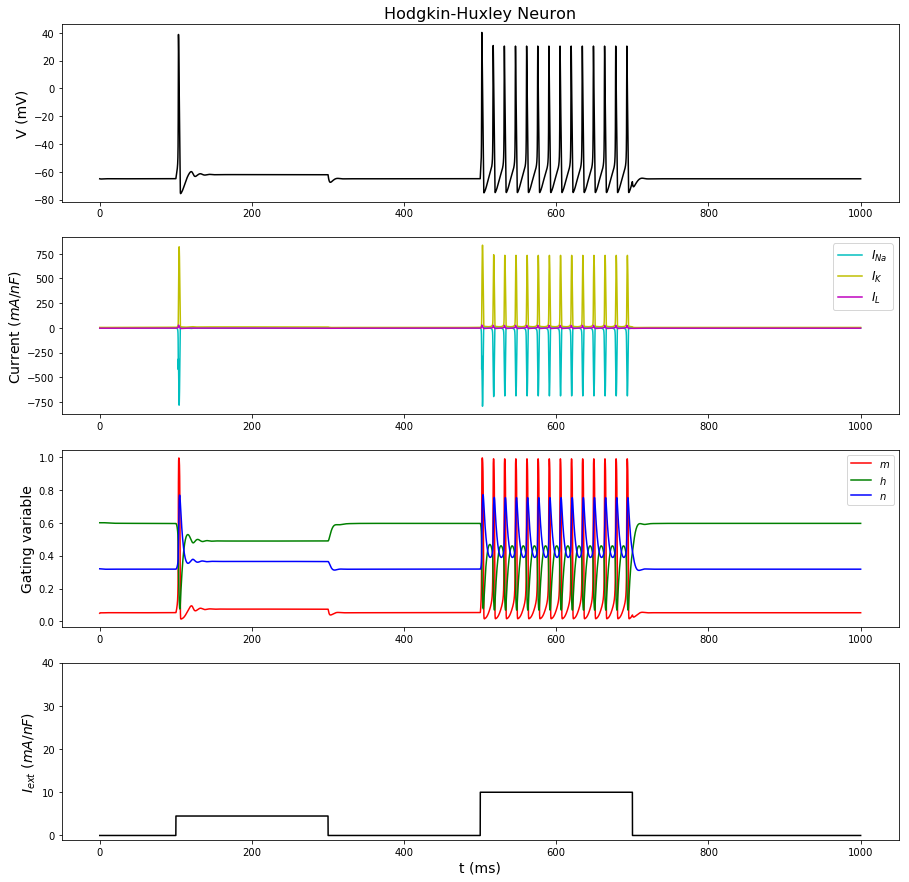

In [43]:
if __name__ == '__main__':
    
    neuron = HodgkinHuxleyNeuron(5, 19, 2.3, 4.5, 10)
    neuron.Euler()
    #neuron.solver()
    #neuron.response_periodic_pulse()
    #neuron.periodic_square_pulse(True)